In [40]:
import pandas as pd
import numpy as np
import snowflake.connector
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from datetime import date
from datetime import timedelta
import datetime
import itertools
import os
import glob
import copy
import warnings
import linecache
import requests
from snowflake.connector.pandas_tools import write_pandas
from snowflake.connector.pandas_tools import pd_writer
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import snowflake.connector

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category = DeprecationWarning)
    warnings.simplefilter("ignore", category = UserWarning)

In [41]:
def get_oauth_token(svc_username=None, svc_password=None):
    """
    Retrives the authentication token for SBD Snowflake.
    This function automatically requests for username and password from the user through interactive prompts.
    If using service account credentials, they can be passed as svc_username and svc_password.
    Keywords:
    svc_username -- Service account username for which the token should be provided.
    svc_password -- Password corresponding to the service account user.
    Example usage:
    # Authentication with your personal user id.
    from sbd_common_utils.snowflake_utils import get_oauth_token
    access_token = get_oauth_token()
    # Authentication with service account.
    from sbd_common_utils.snowflake_utils import get_oauth_token
    from sbd_common_utils.common_utils import get_service_account_creds
    username, password = get_service_account_creds("/datascience/sandbox/someapp/service-account")
    access_token = get_oauth_token(username, password)
    """

    if svc_username and svc_password:
        username = svc_username
        password = svc_password
    else:
        None


    r = requests.post(
        "https://ssoprod.sbdinc.com/as/token.oauth2",
        data={
            "client_id": "Snowflake",
            "grant_type": "password",
            "username": username,
            "password": password,
            "client_secret": 'f9sq630wmLP6UjpSsOk7kTuP6xccCrSOC4YhE1VdTq3GCupqR7gjYcpuhEGRJ9e0',
            "scope": "session:role-any",
        },
    )
    r.raise_for_status()
    access_token = r.json()["access_token"]
    return access_token

In [42]:
'''
Obtain credentials from credentials.txt where 1st line indicates user id, 
2nd line shows password and 3rd line is associated email address.
'''
user_id, user_password, useremail = linecache.getline('credentials.txt', 1).strip(),  linecache.getline('credentials.txt', 2).strip(),  linecache.getline('credentials.txt', 3).strip()

In [43]:
access_token = get_oauth_token(svc_username = user_id, svc_password = user_password)

In [44]:
def check_table_presence(qualified_table_name):
    access_token = get_oauth_token(svc_username = userid, svc_password = password)
    activesnowflakeconnector = snowflake.connector.connect(account = 'sbd_caspian.us-east-1', 
                                                           authenticator = 'oauth', 
                                                           token = access_token,
                                                           warehouse = 'DEV_AIDA_WH',
                                                           database = 'DEV_AIDA',
                                                           role = 'SC_STRATEGY_ANALYTICS_DEV_RW',
                                                           schema = 'SC_STRATEGY_ANALYTICS'
                                                          )
    cur = activesnowflakeconnector.cursor()
    
    # Extract location data 
    try:
        df = pd.DataFrame(cur.execute(f"desc table {qualified_table_name}"))
        return True
    except:
        return False

In [45]:
def drop_table(qualified_table_name):
    access_token = get_oauth_token(svc_username = userid, svc_password = password)
    activesnowflakeconnector = snowflake.connector.connect(account = 'sbd_caspian.us-east-1', 
                                                           authenticator = 'oauth', 
                                                           token = access_token,
                                                           warehouse = 'DEV_AIDA_WH',
                                                           database = 'DEV_AIDA',
                                                           role = 'SC_STRATEGY_ANALYTICS_DEV_RW',
                                                           schema = 'SC_STRATEGY_ANALYTICS'
                                                          )
    cur = activesnowflakeconnector.cursor()
    
    # Extract location data 
    try:
        df = pd.DataFrame(cur.execute(f"drop table {qualified_table_name}"))
        return True
    except:
        return False

In [46]:
def create_table(df, 
                 table_name, 
                 database = 'DEV_AIDA',
                 schema = 'SC_STRATEGY_ANALYTICS'):
    access_token = get_oauth_token(svc_username = userid, svc_password = password)
    engine = create_engine(URL(account = 'sbd_caspian.us-east-1', 
                 authenticator = 'oauth', 
                 token = access_token,
                 warehouse = 'DEV_AIDA_WH',
                 role = 'SC_STRATEGY_ANALYTICS_DEV_RW',
                 database = database,
                 schema = schema
                ))
    connection = engine.connect()

    qualified_table_name = f'{database}.{schema}.{table_name}'
    presence_flag = check_table_presence(qualified_table_name)
    print(f"presence_flag : {presence_flag}")
    if presence_flag == False:    
        df.to_sql(
            table_name, 
            engine, 
            if_exists = "replace", 
            index = False
        )
       
    else:
        #drop_flag = drop_table(qualified_table_name)
        #print(f"drop_flag : {drop_flag}")
        df.to_sql(
            table_name, 
            engine, 
            if_exists = "append", 
            index = False
        )

    connection.close()
    engine.dispose()

In [47]:
df_motor = pd.read_csv('motor_sku_list.csv')
df_motor.head()

,PROD_ID,PROD_TYP_LKEY,SRC_SYS_KEY
0,000000000090560765,HALB,SAPC11
1,CMPSMTRAD,FERT,SAPE03
2,N578553,HALB,SAPE03
3,380285-00,HALB,SAPC11
4,5170021-01,HALB,SAPE03


In [48]:
df_screw = pd.read_csv('screw_sku_list.csv')
df_screw.head()

,PROD_ID,PROD_TYP_LKEY,SRC_SYS_KEY
0,874479SV,HALB,SAPC11
1,498350-00,HALB,SAPC11
2,D216283A01,HALB,SAPE03
3,NA523808,HALB,SAPE03
4,U.17-1620RN,FERT,SAPE03


In [63]:
def build_shipto_query():
    
    consolidated_query_string = ""
    sql = f"""
               SELECT       sls.prod_id
                          , sls.shipto_cust_nbr
                          , sls.shipto_cntry_key
                          , sls.orig_prod_loc_key
                          , sls.fmth_cd
                          , sls.src_sys_key

                          , ROUND(SUM(sls.total_dispatch_dcrncy_amt_usd),2)  AS total_dispatch_dcrncy_amt_usd
                          , ROUND(SUM(sls.total_return_dcrncy_amt_usd), 2)   AS total_return_dcrncy_amt_usd
                          , ROUND(SUM(sls.total_dispatch_invc_qty),0)        AS total_dispatch_invc_qty
                          , ROUND(SUM(sls.total_return_qty), 0)              AS total_return_qty
          
               FROM         dev_aida.sc_strategy_analytics.sc_strategy_fyr_plant_prod_shipto_sales_details sls
               WHERE        sls.shipto_cust_nbr <> 'None'
               GROUP BY     sls.prod_id
                          , sls.shipto_cust_nbr
                          , sls.shipto_cntry_key
                          , sls.orig_prod_loc_key
                          , sls.src_sys_key
                          , sls.fmth_cd
              ;
           """.replace("\t"," ").replace("\n"," ")
    consolidated_query_string += sql
    return consolidated_query_string

In [64]:
orig_df_shipto = pd.DataFrame()
df_shipto = pd.DataFrame()

In [65]:
def get_shipto_data():
    global df_shipto
    global orig_df_shipto
    access_token = get_oauth_token(svc_username = user_id, svc_password = user_password)
    activesnowflakeconnector = snowflake.connector.connect(account = 'sbd_caspian.us-east-1', 
                                                           authenticator = 'oauth', 
                                                           token = access_token,
                                                           warehouse = 'DEV_AIDA_WH',
                                                           database = 'PROD_EDW',
                                                           role = 'SC_STRATEGY_ANALYTICS_DEV_RW',
                                                           schema = 'CONSOLIDATED'
                                                          )
    cur = activesnowflakeconnector.cursor()
    
    df_shipto = pd.DataFrame(cur.execute(build_shipto_query()))
    df_shipto.columns = ['PROD_ID', 
                         'SHIP_TO_CUST_NBR', 
                         'SHIP_TO_COUNTRY',
                         'SHIP_FROM_LOCATION',
                         'FMTH_CD',
                         'SRC_SYS_KEY',
                         'TOTAL_DISPATCH_DCRNCY_AMT_USD', 
                         'TOTAL_RETURN_DCRNCY_AMT_USD',
                         'TOTAL_DISPATCH_INVC_QTY',
                         'TOTAL_RETURN_QTY'
                         ]
    orig_df_shipto = copy.deepcopy(df_shipto)
    #df_shipto = df_shipto[df_shipto.SHIP_TO_CUST_NBR.str.strip() != 'None']

In [66]:
get_shipto_data()

In [67]:
df_shipto.head()

,PROD_ID,SHIP_TO_CUST_NBR,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,FMTH_CD,SRC_SYS_KEY,TOTAL_DISPATCH_DCRNCY_AMT_USD,TOTAL_RETURN_DCRNCY_AMT_USD,TOTAL_DISPATCH_INVC_QTY,TOTAL_RETURN_QTY
0,NA300470,A7500,ID,6500,F2023_M08,SAPE03,82238.70,0.00,26180,0
1,N059591,A5350,NZ,5100,F2023_M01,SAPE03,0.37,0.00,6,0
2,AEF.2X75,0005062943,TW,1600,F2022_M01,SAPE03,128.17,0.00,80,0
3,2-17-205,A2600,ES,4970,F2023_M06,SAPE03,5292.62,0.00,816,0
4,187A.18CPE,A1600,FR,4970,F2022_M11,SAPE03,92249.57,0.00,9580,0


In [68]:
df_screw_sales = pd.merge(df_shipto, df_screw, how = 'inner', on = ['PROD_ID', 'SRC_SYS_KEY'])
df_screw_sales.head()

,PROD_ID,SHIP_TO_CUST_NBR,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,FMTH_CD,SRC_SYS_KEY,TOTAL_DISPATCH_DCRNCY_AMT_USD,TOTAL_RETURN_DCRNCY_AMT_USD,TOTAL_DISPATCH_INVC_QTY,TOTAL_RETURN_QTY,PROD_TYP_LKEY
0,DCF680G2-QW,A1400,IT,4090,F2023_M07,SAPE03,13976.78,0.00,168,0,FERT
1,DCF680G2-QW,0005031024,CY,4000,F2023_M03,SAPE03,330.43,0.00,4,0,FERT
2,DCF680G2-QW,0005031036,GR,4000,F2023_M04,SAPE03,1652.11,0.00,20,0,FERT
3,DCF680G2-QW,A3600,PL,2600,F2022_M12,SAPE03,944.05,0.00,16,0,FERT
4,DCF680G2-QW,0005026463,GR,4000,F2023_M01,SAPE03,330.40,0.00,4,0,FERT


In [69]:
df_screw_sales.shape

(27804, 11)

In [70]:
df_motor_sales = pd.merge(df_shipto, df_motor, how = 'inner', on = ['PROD_ID', 'SRC_SYS_KEY'])
df_motor_sales.head()

,PROD_ID,SHIP_TO_CUST_NBR,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,FMTH_CD,SRC_SYS_KEY,TOTAL_DISPATCH_DCRNCY_AMT_USD,TOTAL_RETURN_DCRNCY_AMT_USD,TOTAL_DISPATCH_INVC_QTY,TOTAL_RETURN_QTY,PROD_TYP_LKEY
0,N481825,A5350,NZ,5100,F2023_M10,SAPE03,892.04,0.00,30,0,HALB
1,N481825,A5350,NZ,5100,F2023_M07,SAPE03,654.17,0.00,22,0,HALB
2,N481825,BRAUS,BR,2560,F2023_M07,SAPE03,13010.30,0.00,372,0,HALB
3,N481825,A3200,GR,2560,F2023_M01,SAPE03,510.94,0.00,12,0,HALB
4,N481825,A10DE,DE,4000,F2023_M08,SAPE03,7244.38,0.00,238,0,HALB


In [71]:
df_motor_sales.shape

(11300, 11)

In [92]:
df_screw_sales_ctry_agg = df_screw_sales.groupby(['SHIP_TO_COUNTRY']).agg({"PROD_ID":['nunique']}).reset_index()
df_screw_sales_ctry_agg.columns = ['SHIP_TO_COUNTRY', 'UNIQUE_PROD_SHIPPED_COUNT']
df_screw_sales_ctry_agg.sort_values(by = ['UNIQUE_PROD_SHIPPED_COUNT'], ascending = False)

,SHIP_TO_COUNTRY,UNIQUE_PROD_SHIPPED_COUNT
11,DE,888
17,GR,621
3,BE,613
15,FR,544
22,IT,435
16,GB,419
38,TH,370
0,AE,319
7,CN,279
31,NZ,254


In [91]:
df_motor_sales_ctry_agg = df_motor_sales.groupby(['SHIP_TO_COUNTRY']).agg({"PROD_ID":['nunique']}).reset_index()
df_motor_sales_ctry_agg.columns = ['SHIP_TO_COUNTRY', 'UNIQUE_PROD_SHIPPED_COUNT']
df_motor_sales_ctry_agg.sort_values(by = ['UNIQUE_PROD_SHIPPED_COUNT'], ascending = False)

,SHIP_TO_COUNTRY,UNIQUE_PROD_SHIPPED_COUNT
7,DE,397
3,BE,292
10,GR,221
28,TR,186
2,AU,178
0,AE,176
8,FR,167
24,RU,150
20,NZ,136
9,GB,135


In [90]:
df_motor_sales_ctry_agg_1 = df_motor_sales.groupby(['SHIP_TO_COUNTRY', 'SHIP_FROM_LOCATION']).agg({"PROD_ID":['nunique']}).reset_index()
df_motor_sales_ctry_agg_1.columns = ['SHIP_TO_COUNTRY', 'SHIP_FROM_LOCATION', 'UNIQUE_PROD_SHIPPED_COUNT']
df_motor_sales_ctry_agg_1.sort_values(by = ['UNIQUE_PROD_SHIPPED_COUNT'], ascending = False)

,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,UNIQUE_PROD_SHIPPED_COUNT
26,DE,4000,394
25,DE,2560,394
11,BE,2560,288
49,GR,2560,214
111,TR,2560,186
...,...,...,...
47,GB,7210,1
75,KR,6500,1
76,MX,2560,1
70,JP,2530,1


In [115]:
df_motor_sales_ctry_agg_1.groupby(['SHIP_TO_COUNTRY']).agg({"SHIP_FROM_LOCATION" : ['nunique']}).reset_index()

,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION
,,nunique
0,AE,4
1,AR,1
2,AU,3
3,BE,4
4,BR,1
5,CL,1
6,CN,10
7,DE,4
8,FR,5


In [95]:
df_screw_sales_ctry_agg_1 = df_screw_sales.groupby(['SHIP_TO_COUNTRY', 'SHIP_FROM_LOCATION']).agg({"PROD_ID":['nunique']}).reset_index()
df_screw_sales_ctry_agg_1.columns = ['SHIP_TO_COUNTRY', 'SHIP_FROM_LOCATION', 'UNIQUE_PROD_SHIPPED_COUNT']
df_screw_sales_ctry_agg_1.sort_values(by = ['UNIQUE_PROD_SHIPPED_COUNT'], ascending = False)

,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,UNIQUE_PROD_SHIPPED_COUNT
76,DE,4000,864
73,DE,2560,784
29,BE,2560,290
127,GR,1600,285
255,TH,6500,266
...,...,...,...
209,PH,6700,1
206,PH,6100,1
201,NZ,969,1
72,DE,2400,1


In [116]:
df_screw_sales_ctry_agg_1.groupby(['SHIP_TO_COUNTRY']).agg({"SHIP_FROM_LOCATION" : ['nunique']}).reset_index()

,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION
,,nunique
0,AE,8
1,AR,1
2,AU,8
3,BE,19
4,BR,5
5,CA,1
6,CL,2
7,CN,13
8,CO,2


<Axes: xlabel='SHIP_TO_COUNTRY', ylabel='UNIQUE_PROD_SHIPPED_COUNT'>

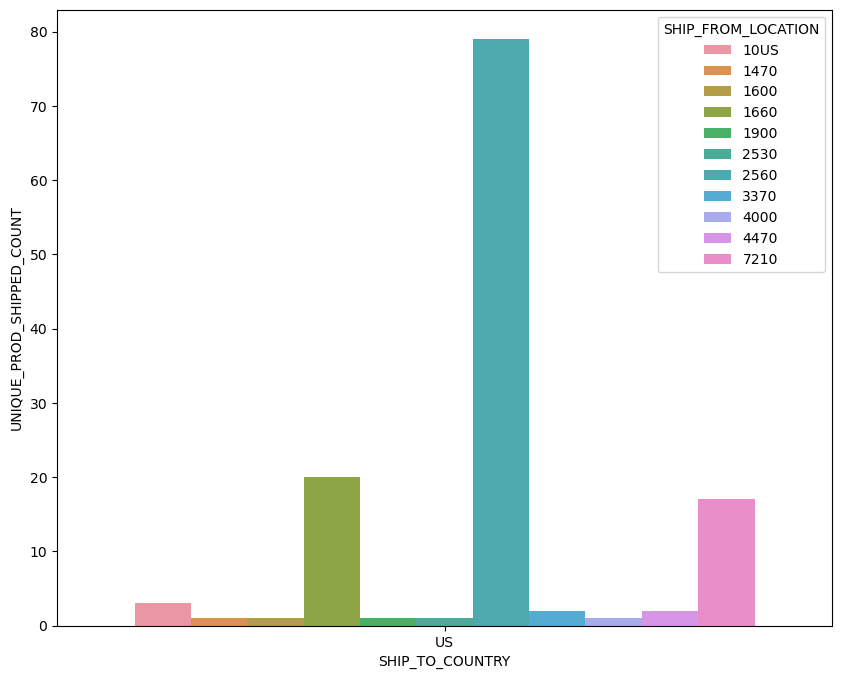

In [121]:
fig,(ax) = plt.subplots(figsize=(10, 8), ncols=1)
sns.barplot(df_screw_sales_ctry_agg_1[df_screw_sales_ctry_agg_1.SHIP_TO_COUNTRY == 'US'], 
            x="SHIP_TO_COUNTRY", 
            y="UNIQUE_PROD_SHIPPED_COUNT", 
            hue="SHIP_FROM_LOCATION")
#ax.get_legend().set_visible(False)

<Axes: xlabel='SHIP_TO_COUNTRY', ylabel='UNIQUE_PROD_SHIPPED_COUNT'>

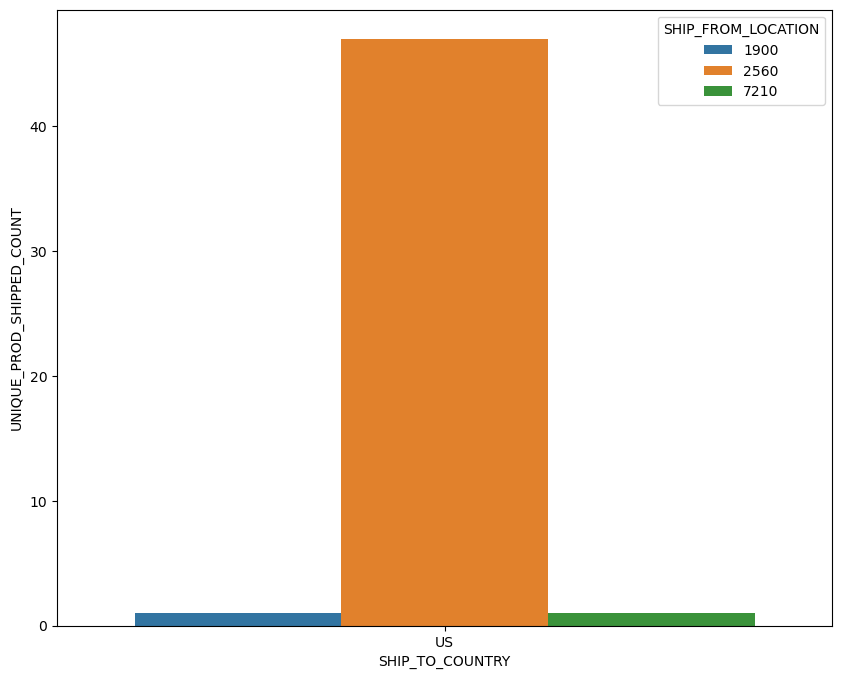

In [123]:
fig,(ax) = plt.subplots(figsize=(10, 8), ncols=1)
sns.barplot(df_motor_sales_ctry_agg_1[df_motor_sales_ctry_agg_1.SHIP_TO_COUNTRY == 'US'], 
            x="SHIP_TO_COUNTRY", 
            y="UNIQUE_PROD_SHIPPED_COUNT", 
            hue="SHIP_FROM_LOCATION")
#ax.get_legend().set_visible(False)

In [80]:
def get_dict(df):
    prod_dict = {}
    for e in df.values:
        prod, cust_cnt = e
        prod_dict[prod] = cust_cnt
    return prod_dict

In [82]:
screw_dict = get_dict(df_screw_sales_ctry_agg)
sorted_screw_dict = dict(sorted(screw_dict.items(), key=lambda item: item[1], reverse=True))
sorted_screw_dict

{'DE': 888,
 'GR': 621,
 'BE': 613,
 'FR': 544,
 'IT': 435,
 'GB': 419,
 'TH': 370,
 'AE': 319,
 'CN': 279,
 'NZ': 254,
 'RU': 246,
 'AU': 230,
 'SE': 225,
 'ID': 202,
 'PL': 199,
 'IN': 181,
 'MY': 163,
 'TR': 144,
 'SG': 143,
 'US': 127,
 'BR': 124,
 'PH': 87,
 'CY': 86,
 'ES': 86,
 'IL': 68,
 'KR': 61,
 'UY': 47,
 'MX': 44,
 'FI': 36,
 'DK': 29,
 'TW': 26,
 'ZA': 23,
 'CO': 18,
 'JP': 12,
 'CL': 10,
 'HK': 10,
 'NO': 10,
 'VN': 10,
 'LK': 8,
 'PE': 7,
 'CZ': 6,
 'AR': 4,
 'NL': 2,
 'CA': 1,
 'MV': 1}

In [83]:
motor_dict = get_dict(df_motor_sales_ctry_agg)
sorted_motor_dict = dict(sorted(motor_dict.items(), key=lambda item: item[1], reverse=True))
sorted_motor_dict

{'DE': 397,
 'BE': 292,
 'GR': 221,
 'TR': 186,
 'AU': 178,
 'AE': 176,
 'FR': 167,
 'RU': 150,
 'NZ': 136,
 'GB': 135,
 'TH': 132,
 'SE': 86,
 'SG': 77,
 'IT': 66,
 'VN': 59,
 'MY': 58,
 'PH': 57,
 'ID': 52,
 'US': 49,
 'IL': 40,
 'IN': 36,
 'CN': 35,
 'BR': 33,
 'ZA': 23,
 'KR': 19,
 'AR': 11,
 'HK': 10,
 'JP': 9,
 'CL': 6,
 'TW': 6,
 'PE': 4,
 'PL': 2,
 'MX': 1}

C:\Users\sxm0326\AppData\Local\Temp\ipykernel_33656\907144484.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


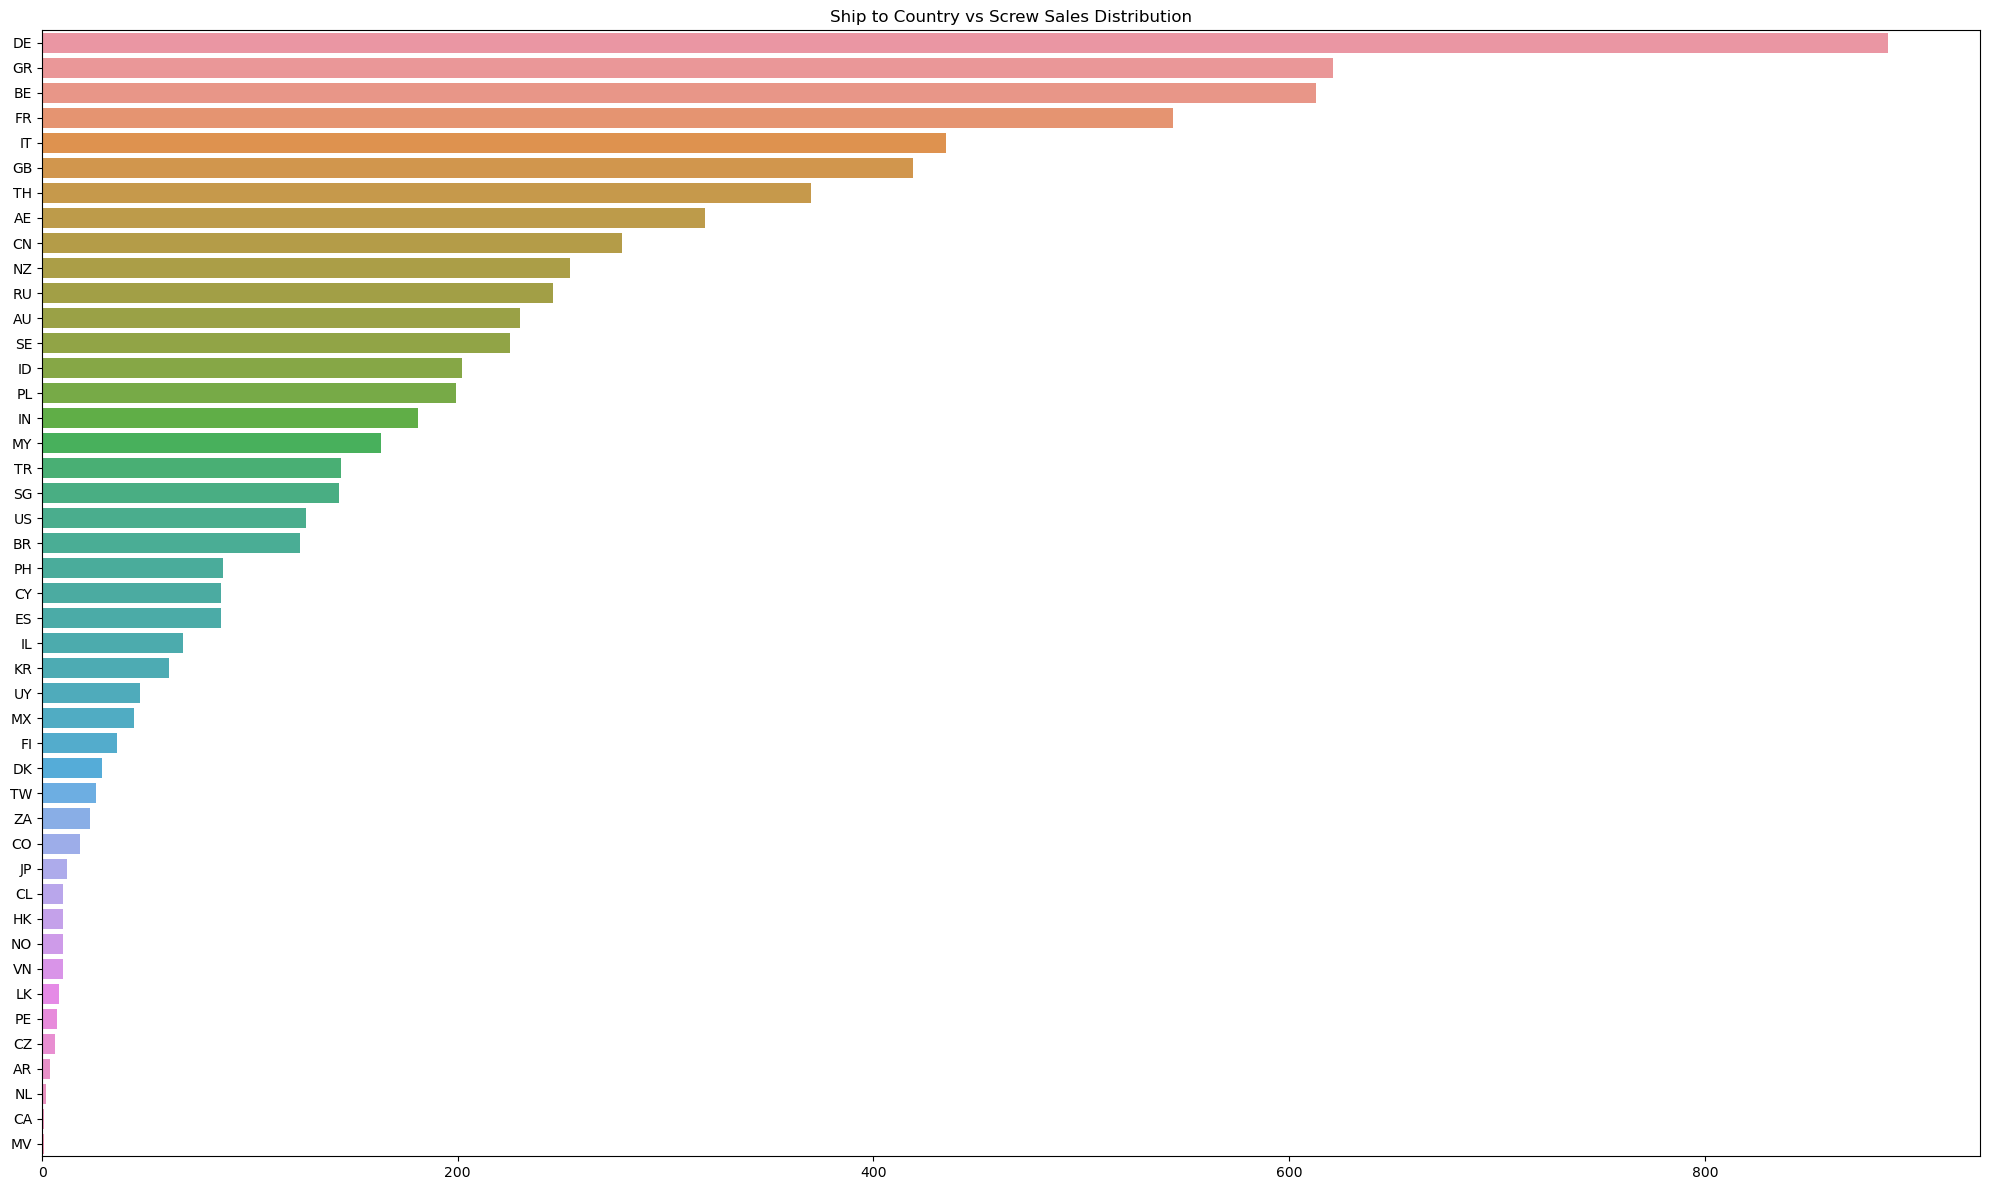

In [96]:
#plt.figure(figsize = (20, 100))
fig,(ax) = plt.subplots(figsize=(20, 12), ncols=1)
#ax = plt.figure().gca()
#plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.figure().gca()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Ship to Country vs Screw Sales Distribution")
sns.barplot(x = list(sorted_screw_dict.values()), y = list(sorted_screw_dict.keys()))
fig.tight_layout()
fig.show()

C:\Users\sxm0326\AppData\Local\Temp\ipykernel_33656\493885210.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


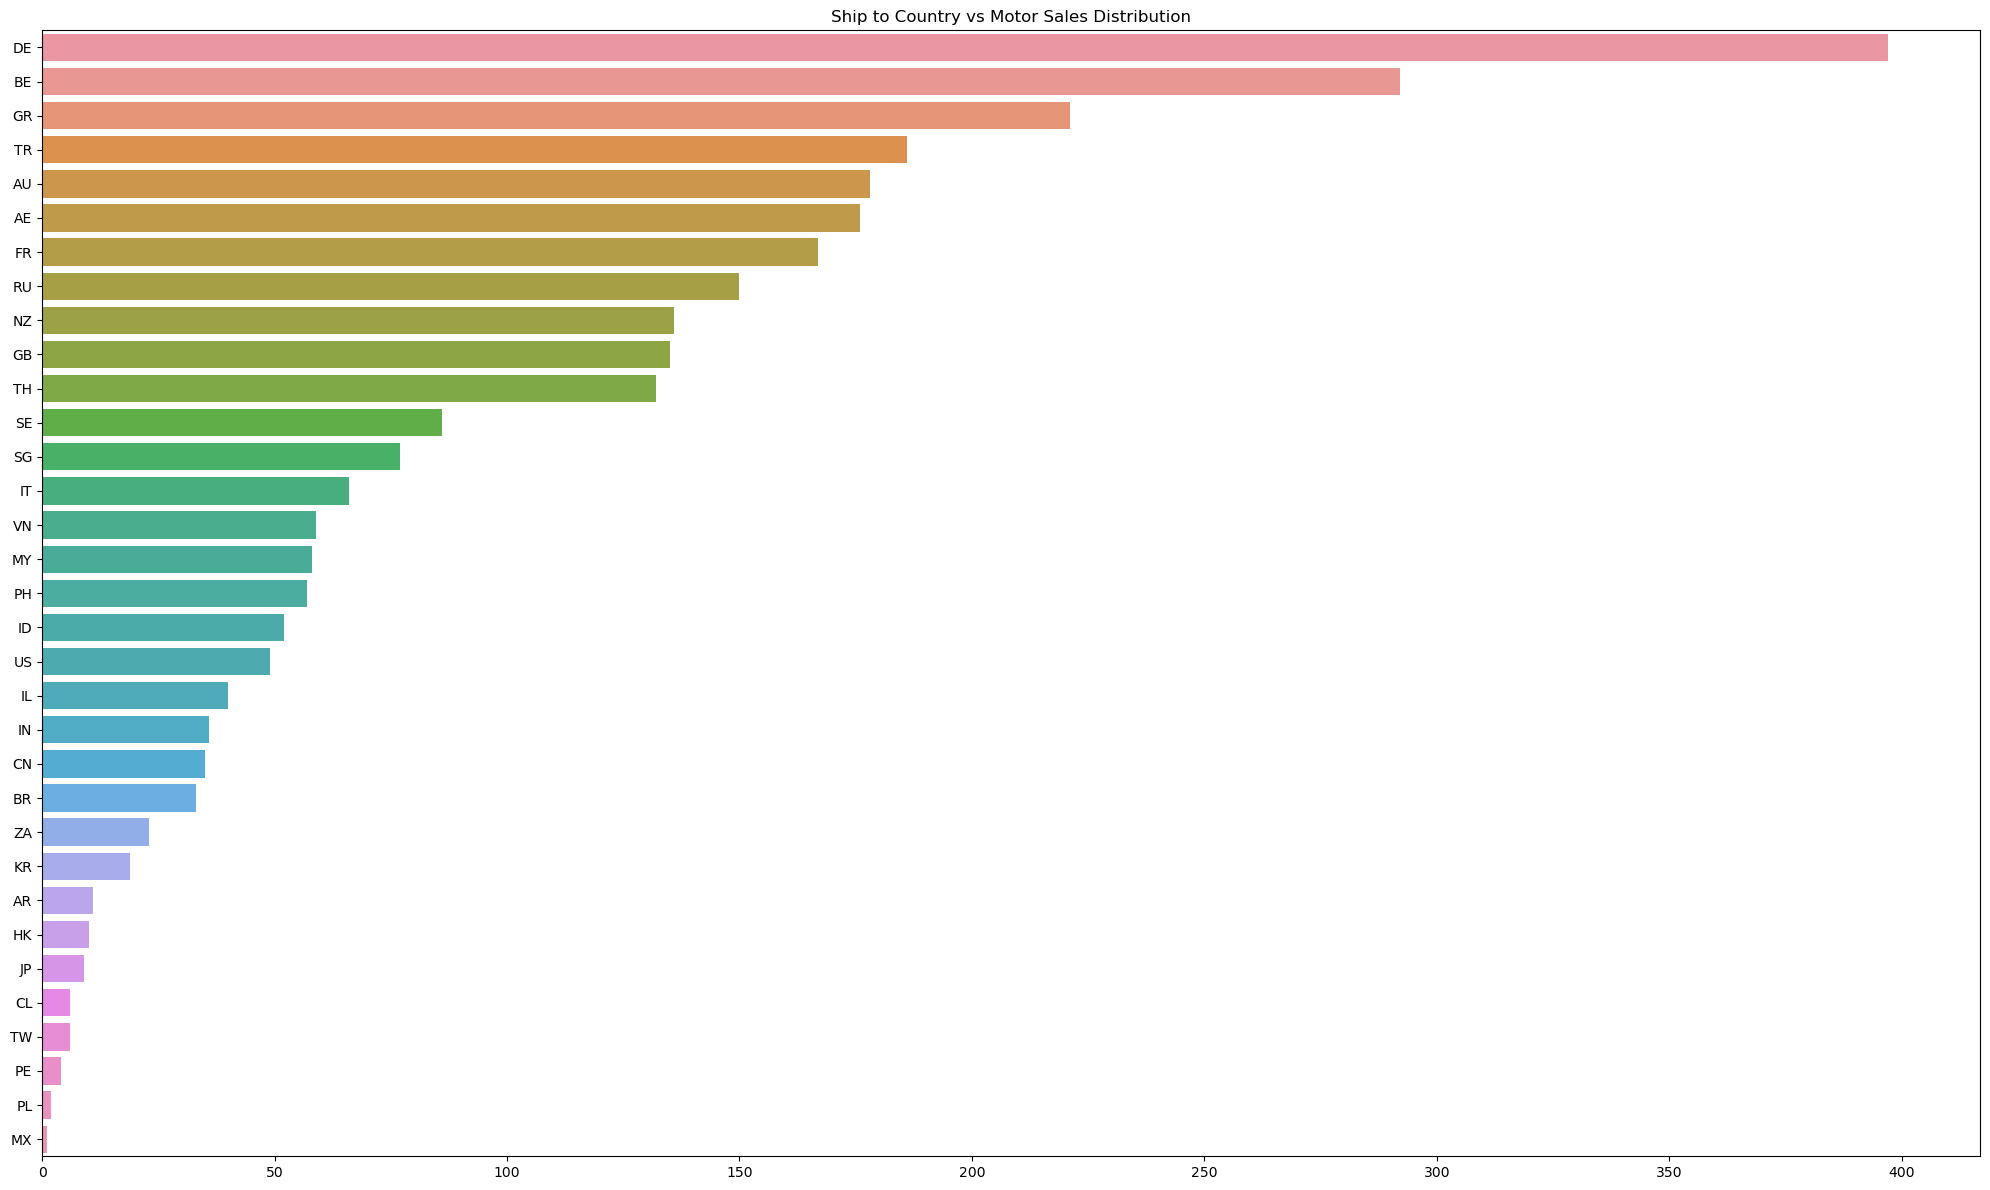

In [97]:
#plt.figure(figsize = (20, 100))
fig,(ax) = plt.subplots(figsize=(20, 12), ncols=1)
#ax = plt.figure().gca()
#plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.figure().gca()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Ship to Country vs Motor Sales Distribution")
sns.barplot(x = list(sorted_motor_dict.values()), y = list(sorted_motor_dict.keys()))
fig.tight_layout()
fig.show()

In [124]:
df_screw_sales.head()

,PROD_ID,SHIP_TO_CUST_NBR,SHIP_TO_COUNTRY,SHIP_FROM_LOCATION,FMTH_CD,SRC_SYS_KEY,TOTAL_DISPATCH_DCRNCY_AMT_USD,TOTAL_RETURN_DCRNCY_AMT_USD,TOTAL_DISPATCH_INVC_QTY,TOTAL_RETURN_QTY,PROD_TYP_LKEY
0,DCF680G2-QW,A1400,IT,4090,F2023_M07,SAPE03,13976.78,0.00,168,0,FERT
1,DCF680G2-QW,0005031024,CY,4000,F2023_M03,SAPE03,330.43,0.00,4,0,FERT
2,DCF680G2-QW,0005031036,GR,4000,F2023_M04,SAPE03,1652.11,0.00,20,0,FERT
3,DCF680G2-QW,A3600,PL,2600,F2022_M12,SAPE03,944.05,0.00,16,0,FERT
4,DCF680G2-QW,0005026463,GR,4000,F2023_M01,SAPE03,330.40,0.00,4,0,FERT


In [126]:
df_screw_sales['year'] = df_screw_sales['FMTH_CD'].apply(lambda x : int(x[1:5]))
df_screw_sales['month'] = df_screw_sales['FMTH_CD'].apply(lambda x : x[6:])   

df_motor_sales['year'] = df_motor_sales['FMTH_CD'].apply(lambda x : int(x[1:5]))
df_motor_sales['month'] = df_motor_sales['FMTH_CD'].apply(lambda x : x[6:])  

In [136]:
df_screw_sales[(df_screw_sales.PROD_ID == 'DCF680G2-QW') & (df_screw_sales.SHIP_TO_COUNTRY == 'DE')][['FMTH_CD','TOTAL_DISPATCH_DCRNCY_AMT_USD']].sort_values(by = ['FMTH_CD'])['TOTAL_DISPATCH_DCRNCY_AMT_USD'].pct_change(12)

84                                 NaN
63                                 NaN
18                                 NaN
108                                NaN
151                                NaN
144                                NaN
132                                NaN
131                                NaN
59                                 NaN
55                                 NaN
44                                 NaN
16                                 NaN
130    -0.4734064744218785059751815372
93     -0.9779867990724529855284354150
147      0.490829795064183195372877725
79     -0.0394333261677685907081849974
106      67.74132710442079764685526430
56       0.063432701319299257443587340
119      1.312165804975476563685088739
109    -0.7762030487738626856590284342
75     -0.6473131370614572133374071059
Name: TOTAL_DISPATCH_DCRNCY_AMT_USD, dtype: object

In [80]:
#df_screw_sales_cust_agg = df_screw_sales.groupby(['PROD_ID', 'SRC_SYS_KEY', 'FYR_ID']).agg({"SOLD_TO_CUST_NBR": ['nunique', 'count']}).reset_index()
df_screw_sales_cust_agg = df_screw_sales.groupby(['PROD_ID', 'SRC_SYS_KEY', 'FMTH_CD']).agg({"SOLD_TO_CUST_NBR": ['nunique']}).reset_index()
df_screw_sales_cust_agg.columns = ['PROD_ID', 'SRC_SYS_KEY', 'FMTH_CD', 'UNIQ_SOLDTO_CUST_CNT']
df_screw_sales_cust_agg.sort_values(by = ['UNIQ_SOLDTO_CUST_CNT'])

,PROD_ID,SRC_SYS_KEY,FMTH_CD,UNIQ_SOLDTO_CUST_CNT
24461,AZPB.1X40,SAPE03,F2023_M03,1
23419,AZ.6.5X200,SAPE03,F2023_M07,1
23417,AZ.6.5X200,SAPE03,F2023_M05,1
23415,AZ.6.5X200,SAPE03,F2023_M03,1
23413,AZ.6.5X200,SAPE03,F2022_M12,1
...,...,...,...,...
28196,DT7969-QZ,SAPE03,F2022_M06,31
28198,DT7969-QZ,SAPE03,F2022_M08,32
28213,DT7969-QZ,SAPE03,F2023_M11,32
28194,DT7969-QZ,SAPE03,F2022_M04,32


In [81]:
df_soldto[df_soldto.PROD_ID == '5170051-15']

,PROD_ID,SOLD_TO_CUST_NBR,FMTH_CD,SRC_SYS_KEY,TOTAL_DISPATCH_DCRNCY_AMT_USD,TOTAL_RETURN_DCRNCY_AMT_USD,TOTAL_DISPATCH_INVC_QTY,TOTAL_RETURN_QTY
673856,5170051-15,A00000954,F2022_M10,SAPC11,0.76,0.00,35,0


In [82]:
df_motor_sales_cust_agg = df_motor_sales.groupby(['PROD_ID', 'SRC_SYS_KEY', 'FMTH_CD']).agg({"SOLD_TO_CUST_NBR": ['nunique']}).reset_index()
df_motor_sales_cust_agg.columns = ['PROD_ID', 'SRC_SYS_KEY', 'FMTH_CD', 'UNIQ_SOLDTO_CUST_CNT']
df_motor_sales_cust_agg.sort_values(by = ['UNIQ_SOLDTO_CUST_CNT'])

,PROD_ID,SRC_SYS_KEY,FMTH_CD,UNIQ_SOLDTO_CUST_CNT
0,000000000090588547,SAPC11,F2023_M07,1
4411,N087486,SAPE03,F2023_M03,1
4410,N087486,SAPE03,F2023_M02,1
4409,N087486,SAPE03,F2023_M01,1
4408,N087486,SAPE03,F2022_M12,1
...,...,...,...,...
10235,NA067843,SAPE03,F2023_M09,31
10938,NA315421,SAPE03,F2023_M10,32
10236,NA067843,SAPE03,F2023_M10,32
5707,N463936,SAPE03,F2023_M09,34


In [83]:
df_motor_sales_cust_agg[(df_motor_sales_cust_agg.PROD_ID == 'N578553') & (df_motor_sales_cust_agg.SRC_SYS_KEY == 'SAPE03')].groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum})

,UNIQ_SOLDTO_CUST_CNT
PROD_ID,
N578553,601


In [84]:
df_motor_sales_cust_agg_c11 = df_motor_sales_cust_agg[df_motor_sales_cust_agg.SRC_SYS_KEY == 'SAPC11']
df_motor_sales_cust_agg_e03 = df_motor_sales_cust_agg[df_motor_sales_cust_agg.SRC_SYS_KEY == 'SAPE03']

df_screw_sales_cust_agg_c11 = df_screw_sales_cust_agg[df_screw_sales_cust_agg.SRC_SYS_KEY == 'SAPC11']
df_screw_sales_cust_agg_e03 = df_screw_sales_cust_agg[df_screw_sales_cust_agg.SRC_SYS_KEY == 'SAPE03']

In [86]:
df_screw_sales_cust_agg_c11.groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum}).reset_index().sort_values(by = ['UNIQ_SOLDTO_CUST_CNT'], ascending = False)

,PROD_ID,UNIQ_SOLDTO_CUST_CNT
144,DCF6202-XJ,26
147,DCF620N-XJ,23
142,DCF601D2-QW,19
146,DCF620D2K-QW,18
150,DT70723-QZ,16
...,...,...
109,5170061-25,1
110,5170062-99,1
111,5170063-05,1
112,5170063-07,1


In [87]:
df_screw_sales_cust_agg_c11[(df_screw_sales_cust_agg_c11.PROD_ID == 'DCF6202-XJ') & (df_screw_sales_cust_agg_c11.SRC_SYS_KEY == 'SAPC11')].groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum})

,UNIQ_SOLDTO_CUST_CNT
PROD_ID,
DCF6202-XJ,26


In [88]:
df_screw_sales_cust_agg[(df_screw_sales_cust_agg.PROD_ID == 'DCF6202-XJ')].groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum})

,UNIQ_SOLDTO_CUST_CNT
PROD_ID,
DCF6202-XJ,540


C:\Users\sxm0326\AppData\Local\Temp\ipykernel_42912\3980543555.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


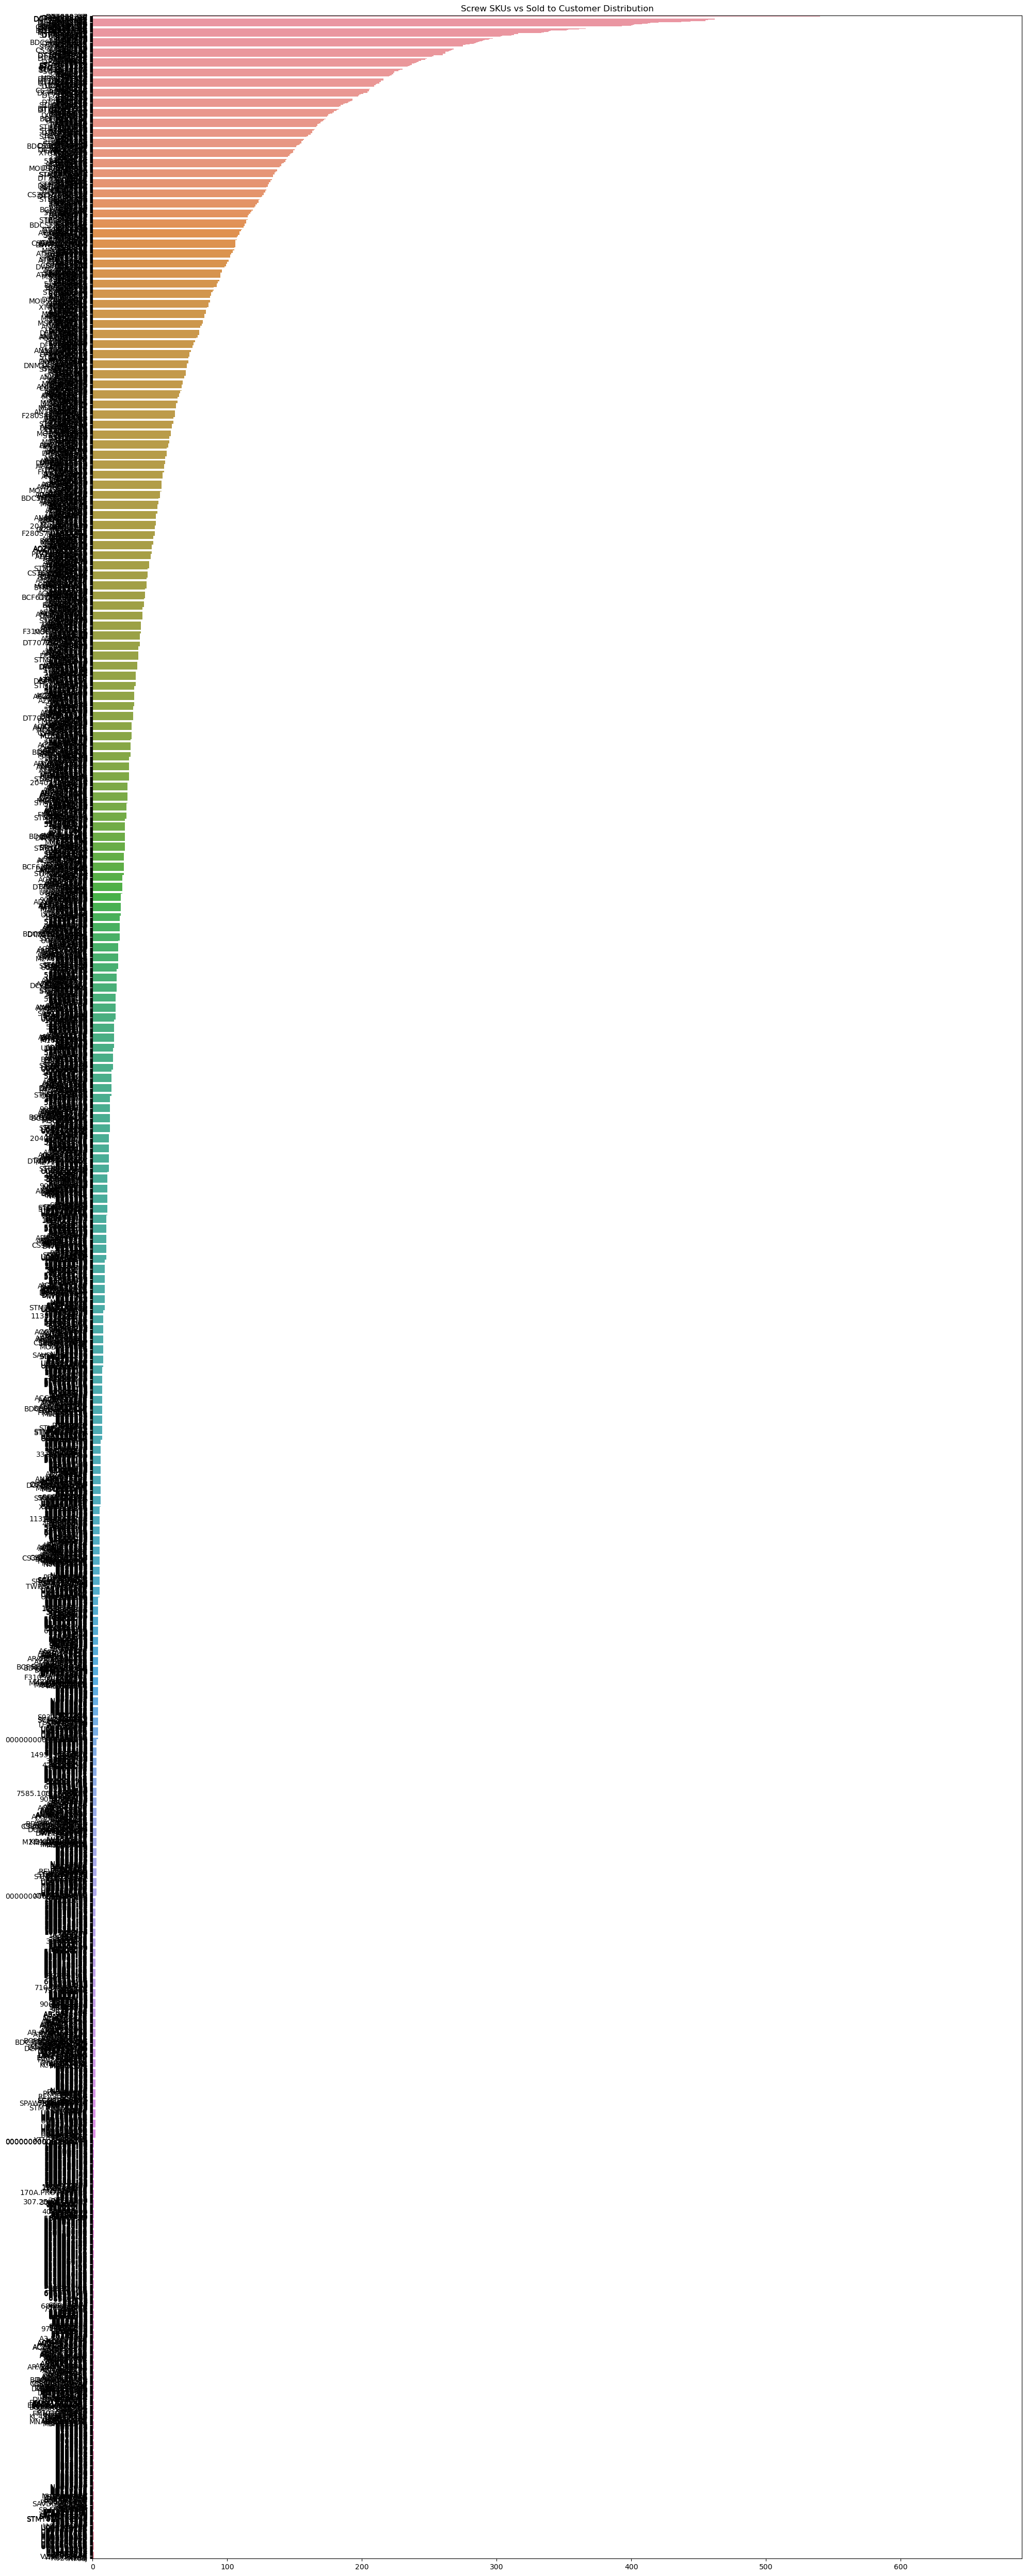

In [91]:
#plt.figure(figsize = (20, 100))
fig,(ax) = plt.subplots(figsize=(20, 50), ncols=1)
#ax = plt.figure().gca()
#plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.figure().gca()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Screw SKUs vs Sold to Customer Distribution")
sns.barplot(x = list(sorted_screw_dict.values()), y = list(sorted_screw_dict.keys()))
fig.tight_layout()
fig.show()

C:\Users\sxm0326\AppData\Local\Temp\ipykernel_42912\4057358268.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


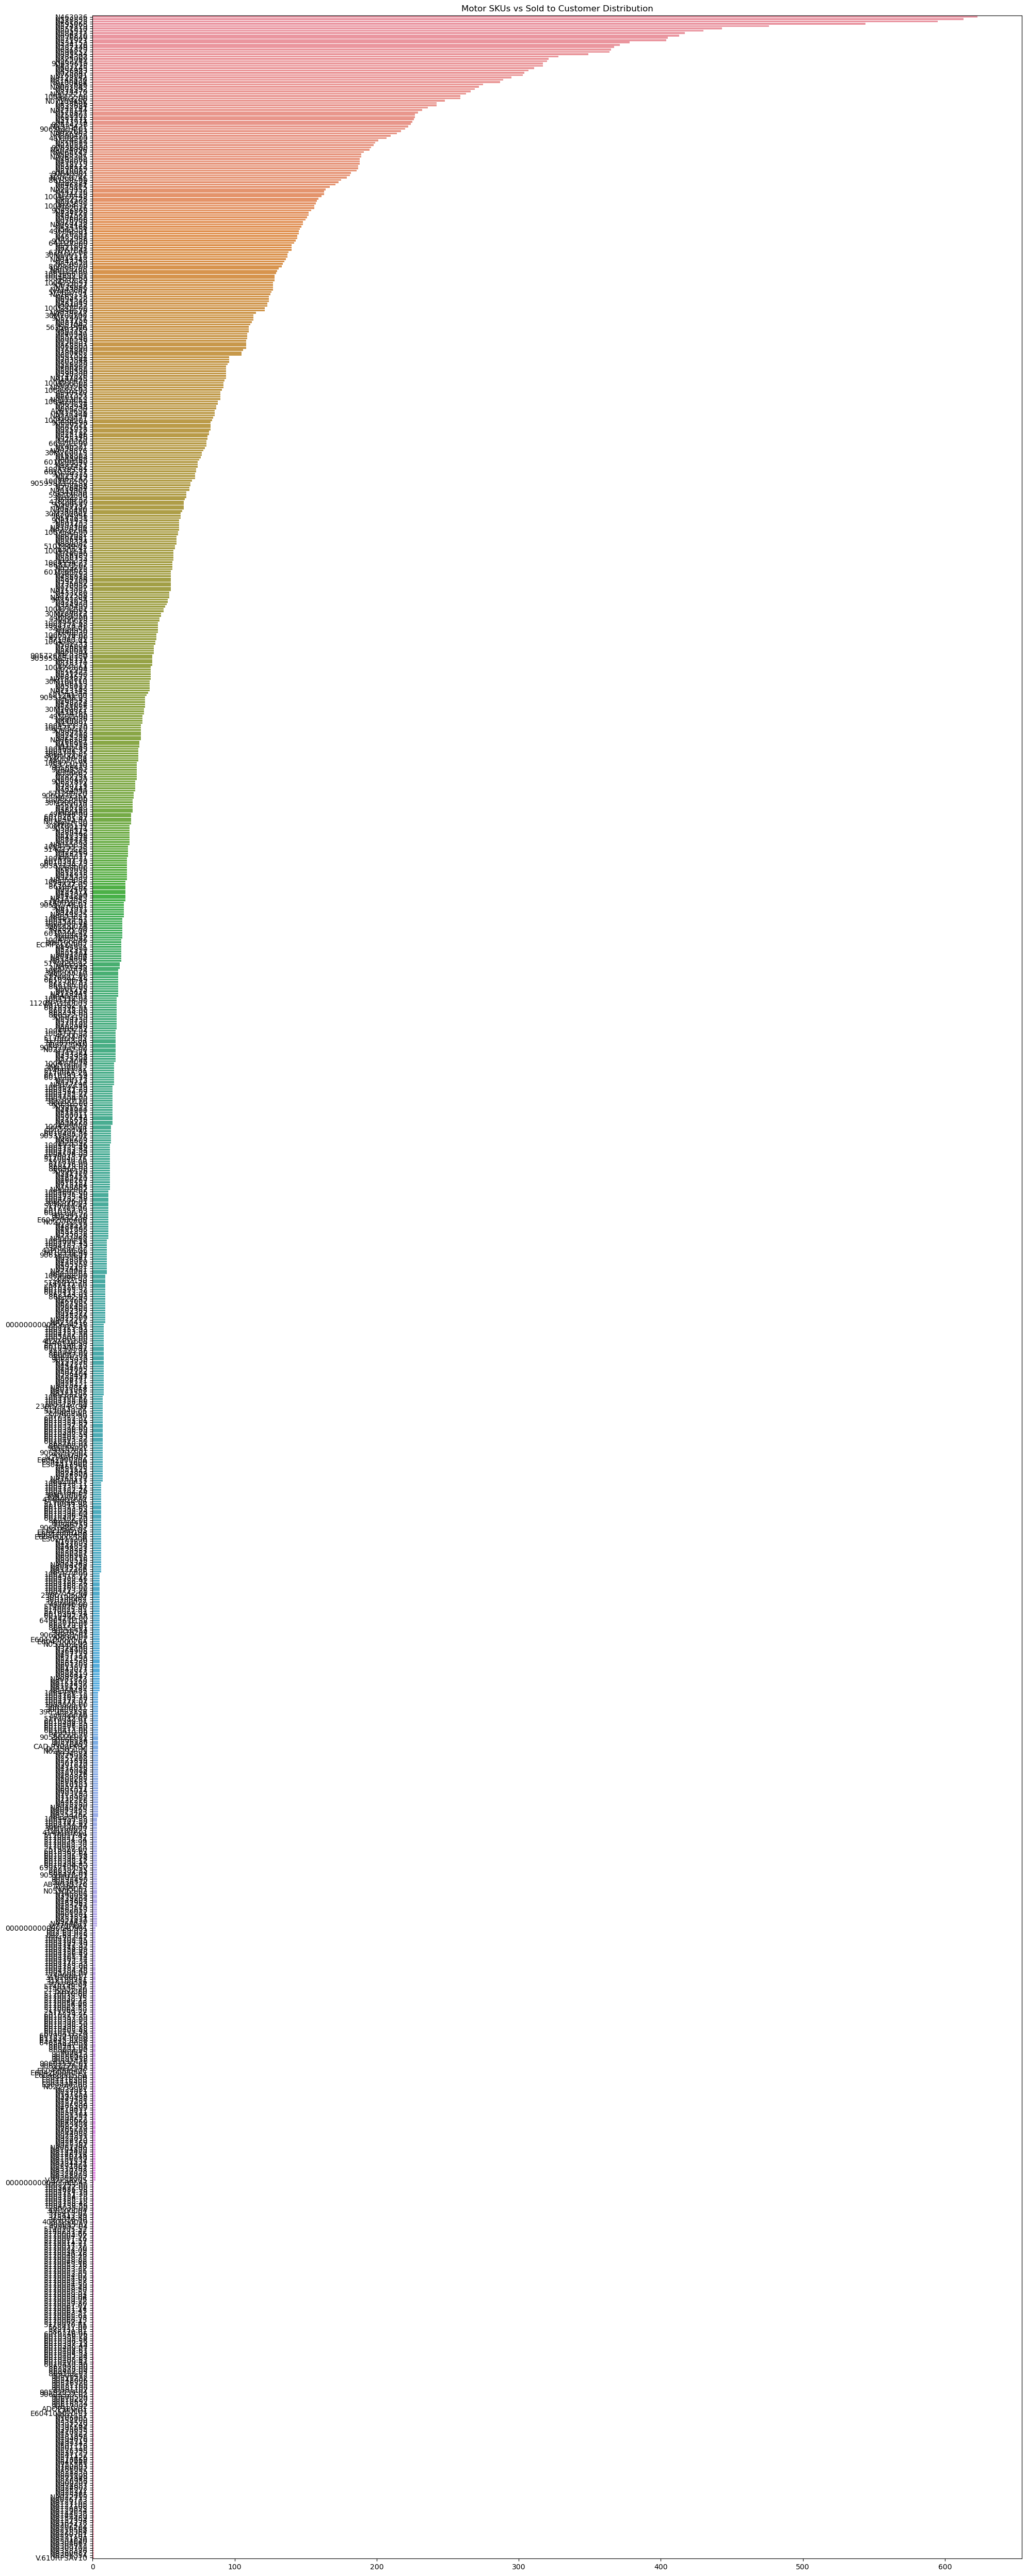

In [92]:
#plt.figure(figsize = (20, 50))
fig,(ax) = plt.subplots(figsize=(20, 50), ncols=1)
#ax = plt.figure().gca()
#plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.figure().gca()
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Motor SKUs vs Sold to Customer Distribution")
sns.barplot(x = list(sorted_motor_dict.values()), y = list(sorted_motor_dict.keys()))
fig.tight_layout()
fig.show()

In [93]:
df_screw_agg = df_screw_sales_cust_agg.groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum}).reset_index()
df_motor_agg = df_motor_sales_cust_agg.groupby(['PROD_ID']).agg({"UNIQ_SOLDTO_CUST_CNT" : np.sum}).reset_index()

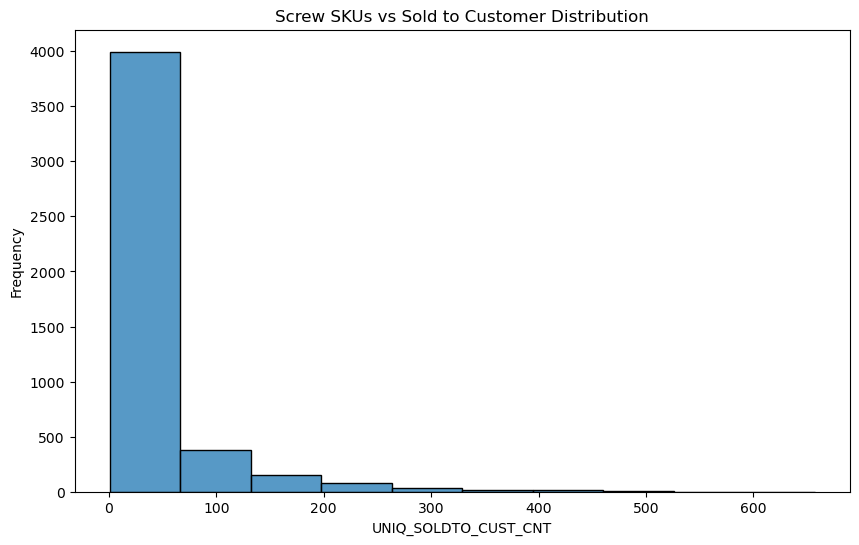

In [94]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_screw_agg, x='UNIQ_SOLDTO_CUST_CNT', bins=10)
plt.title('Screw SKUs vs Sold to Customer Distribution')
plt.xlabel('UNIQ_SOLDTO_CUST_CNT')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

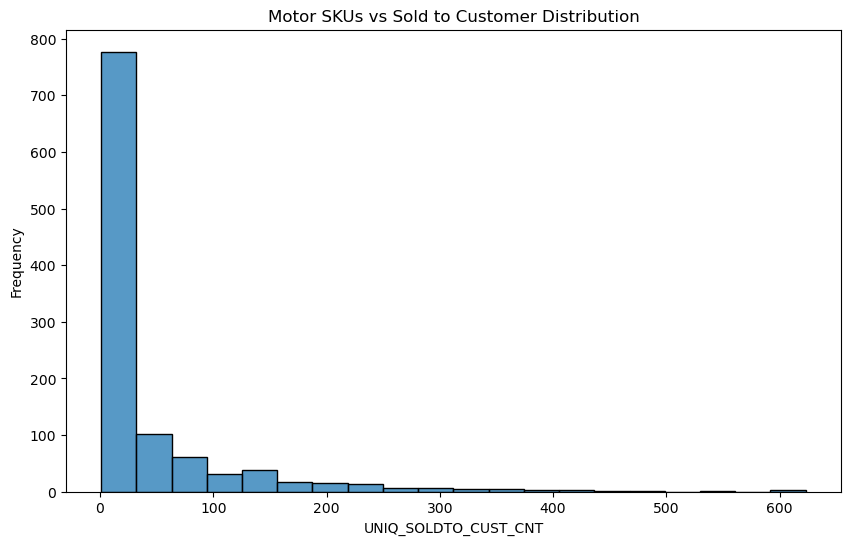

In [95]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_motor_agg, x='UNIQ_SOLDTO_CUST_CNT', bins=20)
plt.title('Motor SKUs vs Sold to Customer Distribution')
plt.xlabel('UNIQ_SOLDTO_CUST_CNT')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [107]:
df_motor_sales_agg = df_motor_sales.groupby(['PROD_ID', 'FMTH_CD']).agg({"TOTAL_DISPATCH_DCRNCY_AMT_USD" : np.sum, "TOTAL_DISPATCH_INVC_QTY" : np.sum}).reset_index()
df_screw_sales_agg = df_screw_sales.groupby(['PROD_ID', 'FMTH_CD']).agg({"TOTAL_DISPATCH_DCRNCY_AMT_USD" : np.sum, "TOTAL_DISPATCH_INVC_QTY" : np.sum}).reset_index()

In [110]:
df_motor_sales_agg_pivot = df_motor_sales_agg.pivot(index='PROD_ID',columns='FMTH_CD', values='TOTAL_DISPATCH_DCRNCY_AMT_USD').reset_index().fillna(0)
df_motor_sales_agg_pivot.head()

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M03,F2023_M04,F2023_M05,F2023_M06,F2023_M07,F2023_M08,F2023_M09,F2023_M10,F2023_M11,F2023_M12
0,000000000090588547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,54.20,0,0,0,0,0
1,000000000090634238,0,0,0,0,0,0,0,98.56,98.56,...,229.20,200.54,200.54,0,0,0,0,0,0,0
2,000000000090640981,0,0,0,0,0,0,0,0,0,...,314.49,0,0,0,0,0,0,0,0,0
3,092-69-022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,092-69-023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
df_motor_sales_agg_pivot.columns

Index(['PROD_ID', 'F2022_M01', 'F2022_M02', 'F2022_M03', 'F2022_M04',
       'F2022_M05', 'F2022_M06', 'F2022_M07', 'F2022_M08', 'F2022_M09',
       'F2022_M10', 'F2022_M11', 'F2022_M12', 'F2023_M01', 'F2023_M02',
       'F2023_M03', 'F2023_M04', 'F2023_M05', 'F2023_M06', 'F2023_M07',
       'F2023_M08', 'F2023_M09', 'F2023_M10', 'F2023_M11', 'F2023_M12'],
      dtype='object', name='FMTH_CD')

In [112]:
df_screw_sales_agg_pivot = df_screw_sales_agg.pivot(index='PROD_ID',columns='FMTH_CD', values='TOTAL_DISPATCH_DCRNCY_AMT_USD').reset_index().fillna(0)
df_screw_sales_agg_pivot.head()

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M03,F2023_M04,F2023_M05,F2023_M06,F2023_M07,F2023_M08,F2023_M09,F2023_M10,F2023_M11,F2023_M12
0,0-64-916,8274.75,9479.52,32658.36,7592.61,7472.77,1658.88,4710.14,1190.01,1863.74,...,972.82,4885.22,5093.30,830.71,1164.12,204.38,367.63,813.16,532.12,529.69
1,0-65-491,23206.03,11121.66,16773.32,3707.19,15279.67,3547.20,14728.64,3670.35,3986.69,...,23186.30,35640.47,17329.57,6718.89,19874.56,5974.10,17024.32,33219.03,17878.18,16825.39
2,0-68-012,24647.74,33054.02,13640.78,5213.09,3478.41,8072.74,6439.29,7097.14,11947.06,...,24527.27,15472.69,13969.34,10812.46,11430.38,9236.99,20944.49,15563.90,10614.35,13238.68
3,0-69-236,0,0,0,0,-9.63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00-1304,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.69,0,0,0,0,0


In [114]:
col_list = ['F2022_M01', 'F2022_M02', 'F2022_M03', 'F2022_M04',
       'F2022_M05', 'F2022_M06', 'F2022_M07', 'F2022_M08', 'F2022_M09',
       'F2022_M10', 'F2022_M11', 'F2022_M12', 'F2023_M01', 'F2023_M02',
       'F2023_M03', 'F2023_M04', 'F2023_M05', 'F2023_M06', 'F2023_M07',
       'F2023_M08', 'F2023_M09', 'F2023_M10', 'F2023_M11', 'F2023_M12']

In [117]:
df_screw_sales_agg_pivot['total_sales'] = df_screw_sales_agg_pivot[col_list].sum(axis = 1)
df_motor_sales_agg_pivot['total_sales'] = df_motor_sales_agg_pivot[col_list].sum(axis = 1)

In [130]:
df_screw_sales_agg_pivot['average_sales'] = df_screw_sales_agg_pivot['total_sales'] / len(col_list)
df_motor_sales_agg_pivot['average_sales'] = df_motor_sales_agg_pivot['total_sales'] / len(col_list)

In [131]:
df_screw_sales_agg_pivot.head()

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M06,F2023_M07,F2023_M08,F2023_M09,F2023_M10,F2023_M11,F2023_M12,average_sales,std_dev,total_sales
0,0-64-916,8274.75,9479.52,32658.36,7592.61,7472.77,1658.88,4710.14,1190.01,1863.74,...,830.71,1164.12,204.38,367.63,813.16,532.12,529.69,4284.572500,NaN,102829.74
1,0-65-491,23206.03,11121.66,16773.32,3707.19,15279.67,3547.20,14728.64,3670.35,3986.69,...,6718.89,19874.56,5974.10,17024.32,33219.03,17878.18,16825.39,14141.034167,NaN,339384.82
2,0-68-012,24647.74,33054.02,13640.78,5213.09,3478.41,8072.74,6439.29,7097.14,11947.06,...,10812.46,11430.38,9236.99,20944.49,15563.90,10614.35,13238.68,12623.602083,NaN,302966.45
3,0-69-236,0,0,0,0,-9.63,0,0,0,0,...,0,0,0,0,0,0,0,-0.401250,NaN,-9.63
4,00-1304,0,0,0,0,0,0,0,0,0,...,0,0.69,0,0,0,0,0,0.028750,NaN,0.69


In [125]:
float(np.std(list(df_screw_sales_agg_pivot[col_list].iloc[0])))

6576.302134169736

In [134]:
std_val_list = []
for i in range(len(df_screw_sales_agg_pivot)):
    std_val = float(np.std(list(df_screw_sales_agg_pivot[col_list].iloc[i])))
    std_val_list.append(std_val)
df_screw_sales_agg_pivot['STD_VAL'] = std_val_list

In [135]:
std_val_list = []
for i in range(len(df_motor_sales_agg_pivot)):
    std_val = float(np.std(list(df_motor_sales_agg_pivot[col_list].iloc[i])))
    std_val_list.append(std_val)
df_motor_sales_agg_pivot['STD_VAL'] = std_val_list

In [136]:
df_motor_sales_agg_pivot.head()

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M07,F2023_M08,F2023_M09,F2023_M10,F2023_M11,F2023_M12,average_sales,std_dev,total_sales,STD_VAL
0,000000000090588547,0,0,0,0,0,0,0,0,0,...,54.20,0,0,0,0,0,2.258333,NaN,54.20,10.830586
1,000000000090634238,0,0,0,0,0,0,0,98.56,98.56,...,0,0,0,0,0,0,44.550000,NaN,1069.20,72.210213
2,000000000090640981,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17.471667,NaN,419.32,65.372991
3,092-69-022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,46.783750,NaN,1122.81,155.164145
4,092-69-023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,411.303333,NaN,9871.28,1364.138832


In [137]:
df_screw_sales_agg_pivot.head()

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M07,F2023_M08,F2023_M09,F2023_M10,F2023_M11,F2023_M12,average_sales,std_dev,total_sales,STD_VAL
0,0-64-916,8274.75,9479.52,32658.36,7592.61,7472.77,1658.88,4710.14,1190.01,1863.74,...,1164.12,204.38,367.63,813.16,532.12,529.69,4284.572500,NaN,102829.74,6576.302134
1,0-65-491,23206.03,11121.66,16773.32,3707.19,15279.67,3547.20,14728.64,3670.35,3986.69,...,19874.56,5974.10,17024.32,33219.03,17878.18,16825.39,14141.034167,NaN,339384.82,8957.048415
2,0-68-012,24647.74,33054.02,13640.78,5213.09,3478.41,8072.74,6439.29,7097.14,11947.06,...,11430.38,9236.99,20944.49,15563.90,10614.35,13238.68,12623.602083,NaN,302966.45,7045.734021
3,0-69-236,0,0,0,0,-9.63,0,0,0,0,...,0,0,0,0,0,0,-0.401250,NaN,-9.63,1.924327
4,00-1304,0,0,0,0,0,0,0,0,0,...,0.69,0,0,0,0,0,0.028750,NaN,0.69,0.137880


In [138]:
df_screw_sales_agg_pivot['CoV']=df_screw_sales_agg_pivot['STD_VAL']/df_screw_sales_agg_pivot['average_sales']
df_motor_sales_agg_pivot['CoV']=df_motor_sales_agg_pivot['STD_VAL']/df_motor_sales_agg_pivot['average_sales']

In [141]:
def condition_xyz(x):
    if x<=0.5:
        return "X"
    elif x>=0.5 and x<=1:
        return "Y"
    else:
        return 'Z'

Coefficient of variance is used for demand/sales uncertainty, variability of products. It is calculated as (standard devaiation of item) divided by (average demand of item). And as a convention, if CoV less than or equal to 0,5, we can classify that product as X, while if Cov between 0,5 and 1, we can assign Y and if CoV greater than 1, which shows the most uncertainty in sales/demand pattern, we assign Z.

In [142]:
df_screw_sales_agg_pivot['XYZ']=df_screw_sales_agg_pivot['CoV'].apply(condition_xyz)
df_screw_sales_agg_pivot.head(10)

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M09,F2023_M10,F2023_M11,F2023_M12,average_sales,std_dev,total_sales,STD_VAL,CoV,XYZ
0,0-64-916,8274.75,9479.52,32658.36,7592.61,7472.77,1658.88,4710.14,1190.01,1863.74,...,367.63,813.16,532.12,529.69,4284.572500,NaN,102829.74,6576.302134,1.534879,Z
1,0-65-491,23206.03,11121.66,16773.32,3707.19,15279.67,3547.20,14728.64,3670.35,3986.69,...,17024.32,33219.03,17878.18,16825.39,14141.034167,NaN,339384.82,8957.048415,0.633408,Y
2,0-68-012,24647.74,33054.02,13640.78,5213.09,3478.41,8072.74,6439.29,7097.14,11947.06,...,20944.49,15563.90,10614.35,13238.68,12623.602083,NaN,302966.45,7045.734021,0.558140,Y
3,0-69-236,0,0,0,0,-9.63,0,0,0,0,...,0,0,0,0,-0.401250,NaN,-9.63,1.924327,-4.795832,X
4,00-1304,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.028750,NaN,0.69,0.137880,4.795832,Z
5,000000000000370748,0,0,0,0,0,0,0,0.04,0,...,0,0,0,0,0.001667,NaN,0.04,0.007993,4.795832,Z
6,000000000090611830,0,0,0,0,0,0,0,0,0,...,0,0,0,0.30,0.015833,NaN,0.38,0.060547,3.824038,Z
7,000000000090614038,0,0,0,0,0,0,0,0,0,...,0.19,0,0,0,0.034167,NaN,0.82,0.129901,3.801985,Z
8,000000000090614124,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.014167,NaN,0.34,0.067941,4.795832,Z
9,056845-00,0,0,1.68,0,0,0,0,0,0,...,0,0,0,0,0.070000,NaN,1.68,0.335708,4.795832,Z


In [143]:
df_motor_sales_agg_pivot['XYZ']=df_motor_sales_agg_pivot['CoV'].apply(condition_xyz)
df_motor_sales_agg_pivot.head(10)

FMTH_CD,PROD_ID,F2022_M01,F2022_M02,F2022_M03,F2022_M04,F2022_M05,F2022_M06,F2022_M07,F2022_M08,F2022_M09,...,F2023_M09,F2023_M10,F2023_M11,F2023_M12,average_sales,std_dev,total_sales,STD_VAL,CoV,XYZ
0,000000000090588547,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.258333,NaN,54.20,10.830586,4.795832,Z
1,000000000090634238,0,0,0,0,0,0,0,98.56,98.56,...,0,0,0,0,44.550000,NaN,1069.20,72.210213,1.620880,Z
2,000000000090640981,0,0,0,0,0,0,0,0,0,...,0,0,0,0,17.471667,NaN,419.32,65.372991,3.741657,Z
3,092-69-022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,46.783750,NaN,1122.81,155.164145,3.316625,Z
4,092-69-023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,411.303333,NaN,9871.28,1364.138832,3.316625,Z
5,092-69-025,0,0,0,0,0,0,0,0,0,...,0,0,0,0,125.378333,NaN,3009.08,415.832889,3.316625,Z
6,1002577-00,0,31.88,0,0,0,0,0,0,0,...,0,0,0,0,6.160833,NaN,147.86,16.872134,2.738612,Z
7,1002753-00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.308333,NaN,-7.40,1.478715,-4.795832,X
8,1003270-00,106.80,369.47,79.68,83.73,83.73,162.00,83.73,78.26,0,...,0,151.13,0,0,68.575833,NaN,1645.82,84.607105,1.233774,Z
9,1003477-00,445.06,0,0,0,0,0,0,0,0,...,0,0,0,0,18.544167,NaN,445.06,88.934699,4.795832,Z


In [146]:
df_motor_sales_agg_1 = df_motor_sales_agg.groupby('PROD_ID').agg({"TOTAL_DISPATCH_DCRNCY_AMT_USD" : np.sum}).sort_values(by='TOTAL_DISPATCH_DCRNCY_AMT_USD', ascending=False).reset_index()
df_screw_sales_agg_1 = df_screw_sales_agg.groupby('PROD_ID').agg({"TOTAL_DISPATCH_DCRNCY_AMT_USD" : np.sum}).sort_values(by='TOTAL_DISPATCH_DCRNCY_AMT_USD', ascending=False).reset_index()

In [149]:
df_motor_sales_agg_1['rev_cum_sum'] = df_motor_sales_agg_1['TOTAL_DISPATCH_DCRNCY_AMT_USD'].cumsum()
df_motor_sales_agg_1['rev_all'] = df_motor_sales_agg_1['TOTAL_DISPATCH_DCRNCY_AMT_USD'].sum()
df_motor_sales_agg_1['sku_rev_percent'] = df_motor_sales_agg_1['rev_cum_sum']/df_motor_sales_agg_1['rev_all']
df_motor_sales_agg_1.head(100)

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,rev_cum_sum,rev_all,sku_rev_percent
0,496846-01,8987300.62,8987300.62,74475781.28,0.1206741368205489740382351582
1,N463936,8228499.95,17215800.57,74475781.28,0.2311597176171308504600087627
2,N158402,4092559.58,21308360.15,74475781.28,0.2861112670961966174354713664
3,496846-00,3391714.16,24700074.31,74475781.28,0.3316524363421891181535517824
4,579827-04,3146047.15,27846121.46,74475781.28,0.3738949895041638158696735460
...,...,...,...,...,...
95,N675711,76435.48,70688298.24,74475781.28,0.9491447692806264710594251855
96,N342741,71784.20,70760082.44,74475781.28,0.9501086289242080442395326826
97,N684207,69885.04,70829967.48,74475781.28,0.9510469881975033374231962136
98,N102229,69070.28,70899037.76,74475781.28,0.9519744075385683553852340332


In [150]:
df_screw_sales_agg_1['rev_cum_sum'] = df_screw_sales_agg_1['TOTAL_DISPATCH_DCRNCY_AMT_USD'].cumsum()
df_screw_sales_agg_1['rev_all'] = df_screw_sales_agg_1['TOTAL_DISPATCH_DCRNCY_AMT_USD'].sum()
df_screw_sales_agg_1['sku_rev_percent'] = df_screw_sales_agg_1['rev_cum_sum']/df_screw_sales_agg_1['rev_all']
df_screw_sales_agg_1.head(100)

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,rev_cum_sum,rev_all,sku_rev_percent
0,DT7969-QZ,5633360.80,5633360.80,127332130.78,0.04424147122561801521750989425
1,BDHT84014-0,5458538.11,11091898.91,127332130.78,0.08710997642193072864558247519
2,CS36BSC-QW,5441707.57,16533606.48,127332130.78,0.1298463033542271175680705906
3,DT70731T-QZ,4047594.71,20581201.19,127332130.78,0.1616339965720001909481907753
4,DCF680G2-QW,3523948.09,24105149.28,127332130.78,0.1893092429407942088629202785
...,...,...,...,...,...
95,DW274KN-QS,268208.36,90645581.49,127332130.78,0.7118830175442069987796366946
96,BDCSFL20AT-GB,267055.76,90912637.25,127332130.78,0.7139803338960507419539783186
97,DW274-QS,266783.45,91179420.70,127332130.78,0.7160755116674880165702038211
98,DT70783T-QZ,263618.43,91443039.13,127332130.78,0.7181458330261674743019642414


In [151]:
def condition_abc(x):
    if x>0 and x<=0.80:
        return "A"
    elif x>0.80 and x<=0.90:
        return "B"
    else:
        return 'C'

A class : SKUs making top 80% of revenue
B Class : Next 10% of revenue (A+B , now, makes 90% of total revenue)
C class: Remaining SKUs making last 10% of revenue

In [152]:
df_screw_sales_agg_1['ABC']=df_screw_sales_agg_1['sku_rev_percent'].apply(condition_abc)
df_screw_sales_agg_1.tail(10)

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,rev_cum_sum,rev_all,sku_rev_percent,ABC
4663,CS3652OA-QW,-633.40,127376389.60,127332130.78,1.000347585638667029302342756,C
4664,ANXR10X75F,-734.47,127375655.13,127332130.78,1.000341817495186661479348567,C
4665,ANXR15X75F,-814.13,127374841.00,127332130.78,1.000335423743703725681107306,C
4666,ANXR25X100,-893.95,127373947.05,127332130.78,1.000328403127661852200412852,C
4667,BDAS36V-QW,-897.25,127373049.80,127332130.78,1.000321356595144853508592170,C
4668,MOD.A1,-1221.37,127371828.43,127332130.78,1.000311764593561920443973584,C
4669,NS.260PF,-1328.98,127370499.45,127332130.78,1.000301327479285586176538811,C
4670,CS36BSCES-QW,-1579.23,127368920.22,127332130.78,1.000288925032312256732031733,C
4671,AGT.8X100,-8126.47,127360793.75,127332130.78,1.000225103984551415986286380,C
4672,330019-62,-28662.97,127332130.78,127332130.78,1,C


In [153]:
df_motor_sales_agg_1['ABC']=df_motor_sales_agg_1['sku_rev_percent'].apply(condition_abc)
df_motor_sales_agg_1.tail(10)

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,rev_cum_sum,rev_all,sku_rev_percent,ABC
1081,375941-49,-26.13,76040696.42,74475781.28,1.021012403134336075272388200,C
1082,375413-07,-30.12,76040666.30,74475781.28,1.021011998707561594579085428,C
1083,568427-00,-36.71,76040629.59,74475781.28,1.021011505795646216549498949,C
1084,375413-09,-39.57,76040590.02,74475781.28,1.021010974481985320100827279,C
1085,868407-04,-61.32,76040528.70,74475781.28,1.021010151127077911199322433,C
1086,E604100020-E1,-69.25,76040459.45,74475781.28,1.021009221294603383044899559,C
1087,1005200-00,-208.80,76040250.65,74475781.28,1.021006417698636863497701061,C
1088,30M100139,-2485.53,76037765.12,74475781.28,1.020973044030616445249864454,C
1089,N460440,-3965.79,76033799.33,74475781.28,1.020919794639581658108655963,C
1090,N497719,-1558018.05,74475781.28,74475781.28,1,C


In [158]:
df_motor_sales_agg_m1 = df_motor_sales_agg_pivot[['PROD_ID','total_sales', 'average_sales','STD_VAL','CoV','XYZ']]
df_motor_sales_agg_m2 = df_motor_sales_agg_1[['PROD_ID','TOTAL_DISPATCH_DCRNCY_AMT_USD','ABC']]
df_motor_final = df_motor_sales_agg_m2.merge(df_motor_sales_agg_m1, on = 'PROD_ID', how='left')
df_motor_final.head()

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ
0,496846-01,8987300.62,A,8987300.62,374470.859167,885220.799279,2.363924,Z
1,N463936,8228499.95,A,8228499.95,342854.164583,259613.078617,0.757211,Y
2,N158402,4092559.58,A,4092559.58,170523.315833,285980.925993,1.677078,Z
3,496846-00,3391714.16,A,3391714.16,141321.423333,247137.681729,1.748763,Z
4,579827-04,3146047.15,A,3146047.15,131085.297917,288729.293409,2.202606,Z


In [159]:
df_screw_sales_agg_m1 = df_screw_sales_agg_pivot[['PROD_ID','total_sales', 'average_sales','STD_VAL','CoV','XYZ']]
df_screw_sales_agg_m2 = df_screw_sales_agg_1[['PROD_ID','TOTAL_DISPATCH_DCRNCY_AMT_USD','ABC']]
df_screw_final = df_screw_sales_agg_m2.merge(df_screw_sales_agg_m1, on = 'PROD_ID', how='left')
df_screw_final.head()

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ
0,DT7969-QZ,5633360.80,A,5633360.80,234723.366667,155959.217960,0.664438,Y
1,BDHT84014-0,5458538.11,A,5458538.11,227439.087917,552206.296295,2.427930,Z
2,CS36BSC-QW,5441707.57,A,5441707.57,226737.815417,336390.496604,1.483610,Z
3,DT70731T-QZ,4047594.71,A,4047594.71,168649.779583,112192.685946,0.665241,Y
4,DCF680G2-QW,3523948.09,A,3523948.09,146831.170417,97537.517857,0.664283,Y


In [168]:
df_screw_final = pd.merge(df_screw_final, df_screw_agg, on = 'PROD_ID', how='left')
df_motor_final = pd.merge(df_motor_final, df_motor_agg, on = 'PROD_ID', how='left')

In [169]:
df_screw_final.head()

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
0,DT7969-QZ,5633360.80,A,5633360.80,234723.366667,155959.217960,0.664438,Y,657
1,BDHT84014-0,5458538.11,A,5458538.11,227439.087917,552206.296295,2.427930,Z,6
2,CS36BSC-QW,5441707.57,A,5441707.57,226737.815417,336390.496604,1.483610,Z,66
3,DT70731T-QZ,4047594.71,A,4047594.71,168649.779583,112192.685946,0.665241,Y,455
4,DCF680G2-QW,3523948.09,A,3523948.09,146831.170417,97537.517857,0.664283,Y,509


In [170]:
df_motor_final.head()

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
0,496846-01,8987300.62,A,8987300.62,374470.859167,885220.799279,2.363924,Z,145
1,N463936,8228499.95,A,8228499.95,342854.164583,259613.078617,0.757211,Y,623
2,N158402,4092559.58,A,4092559.58,170523.315833,285980.925993,1.677078,Z,227
3,496846-00,3391714.16,A,3391714.16,141321.423333,247137.681729,1.748763,Z,27
4,579827-04,3146047.15,A,3146047.15,131085.297917,288729.293409,2.202606,Z,126


In [161]:
df_screw_final[['ABC','XYZ']].value_counts()

ABC  XYZ
C    Z      3817
     Y       326
     X       266
A    Z        79
B    Z        68
A    Y        56
B    Y        43
A    X        12
B    X         6
dtype: int64

In [162]:
df_motor_final[['ABC','XYZ']].value_counts()

ABC  XYZ
C    Z      892
     Y      110
A    Z       28
C    X       28
B    Y       14
     Z       10
A    X        3
     Y        3
B    X        3
dtype: int64

In [171]:
df_motor_final[(df_motor_final.ABC == 'A') & (df_motor_final.XYZ == 'X')]

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
9,N481825,1775869.95,A,1775869.95,73994.581250,35215.769084,0.475924,X,595
11,N578553,1411238.57,A,1411238.57,58801.607083,13139.175614,0.223449,X,613
18,N534153,981105.32,A,981105.32,40879.388333,20285.447041,0.496227,X,378


In [172]:
df_motor_final[(df_motor_final.ABC == 'C') & (df_motor_final.XYZ == 'Z')]

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
62,N382016,157194.93,C,157194.93,6549.788750,7526.039379,1.149051,Z,156
63,N557208,153182.63,C,153182.63,6382.609583,7095.232282,1.111651,Z,109
65,N483510,140353.27,C,140353.27,5848.052917,27167.946695,4.645640,Z,3
70,NA039647,123338.78,C,123338.78,5139.115833,9360.910437,1.821502,Z,115
71,NA034896,117713.00,C,117713.00,4904.708333,6198.166512,1.263718,Z,195
...,...,...,...,...,...,...,...,...,...
1067,N766097,0.00,C,0.00,0.000000,0.000000,NaN,Z,1
1068,90603327-02,0.00,C,0.00,0.000000,0.000000,NaN,Z,1
1069,90581105,0.00,C,0.00,0.000000,0.000000,NaN,Z,1
1070,N501118,0.00,C,0.00,0.000000,0.000000,NaN,Z,1


In [174]:
df_screw_final[(df_screw_final.ABC == 'A') & (df_screw_final.XYZ == 'X')]

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
12,BCF611CK-QW,1368303.58,A,1368303.58,57012.649167,22888.668575,0.401466,X,352
22,DCF6202-XJ,967561.63,A,967561.63,40315.067917,13353.671681,0.331233,X,540
28,AT5.5X100,814908.05,A,814908.05,33954.502083,16845.585763,0.496122,X,420
31,E160910,770073.47,A,770073.47,32086.394583,14298.428377,0.445623,X,275
51,DCF620E1K-XJ,521558.10,A,521558.10,21731.587500,10680.539705,0.491475,X,204
56,E160911,489039.57,A,489039.57,20376.648750,10127.277359,0.497004,X,224
63,DCF601D2-GB,414022.13,A,414022.13,17250.922083,7943.400778,0.460462,X,46
66,E160907,382933.54,A,382933.54,15955.564167,7560.010126,0.473817,X,237
76,DT71511-QZ,337586.27,A,337586.27,14066.094583,5800.133448,0.412349,X,316
90,E160902,280964.90,A,280964.90,11706.870833,5845.009131,0.499280,X,224


In [173]:
df_screw_final[(df_screw_final.ABC == 'C') & (df_screw_final.XYZ == 'Z')]

,PROD_ID,TOTAL_DISPATCH_DCRNCY_AMT_USD,ABC,total_sales,average_sales,STD_VAL,CoV,XYZ,UNIQ_SOLDTO_CUST_CNT
264,STA62875-XJ,66444.98,C,66444.98,2768.540833,4398.306667,1.588673,Z,43
265,CS3651LC-GB,66304.32,C,66304.32,2762.680000,3590.997095,1.299824,Z,29
268,326573-01,64860.93,C,64860.93,2702.538750,6078.065972,2.249021,Z,220
269,STA88563-XJ,64655.95,C,64655.95,2693.997917,3314.016286,1.230148,Z,111
270,DFM3510300,64511.73,C,64511.73,2687.988750,3172.919147,1.180406,Z,75
...,...,...,...,...,...,...,...,...,...
4455,AC.4X75,0.00,C,0.00,0.000000,0.000000,NaN,Z,2
4456,AC.4X250,0.00,C,0.00,0.000000,0.000000,NaN,Z,2
4457,AC.4X100,0.00,C,0.00,0.000000,0.000000,NaN,Z,28
4458,AC.3X50,0.00,C,0.00,0.000000,0.000000,NaN,Z,1


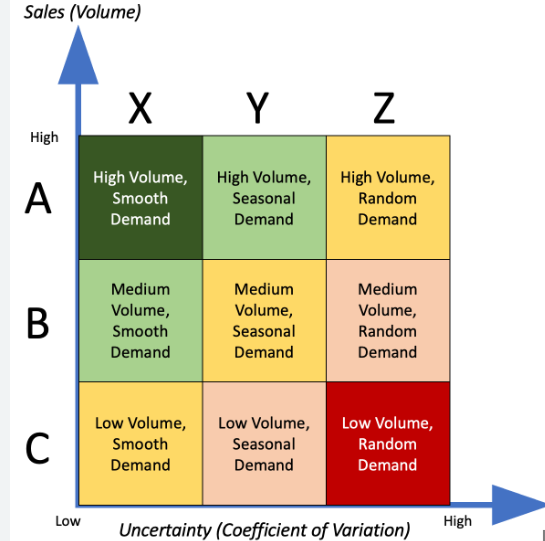

In [175]:
df_screw_final[(df_screw_final.ABC == 'C') & ((df_screw_final.XYZ == 'Z') | ((df_screw_final.XYZ == 'Y')))]['PROD_ID']

264     STA62875-XJ
265     CS3651LC-GB
267      U03240403R
268       326573-01
269     STA88563-XJ
           ...     
4455        AC.4X75
4456       AC.4X250
4457       AC.4X100
4458        AC.3X50
4459        AC.3X75
Name: PROD_ID, Length: 4143, dtype: object

In [176]:
df_motor_final[(df_motor_final.ABC == 'C') & ((df_motor_final.XYZ == 'Z') | ((df_motor_final.XYZ == 'Y')))]['PROD_ID']

61          N632686
62          N382016
63          N557208
65          N483510
67          N825069
           ...     
1067        N766097
1068    90603327-02
1069       90581105
1070        N501118
1071        N501116
Name: PROD_ID, Length: 1002, dtype: object